In [23]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

#  Define cleaning function
def clean_energy_data(file_path):
    df = pd.read_csv(
        file_path,
        sep=";",
        na_values="?",
        low_memory=False
    )


    numeric_cols = [
        "Global_active_power",
        "Global_reactive_power",
        "Voltage",
        "Global_intensity",
        "Sub_metering_1",
        "Sub_metering_2",
        "Sub_metering_3"
    ]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # Merge Date & Time into Datetime
    if "Date" in df.columns and "Time" in df.columns:
        df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")
        df = df.sort_values("Datetime")

    # Drop rows without consumption and create lag
    if "Global_active_power" in df.columns:
        df = df.dropna(subset=["Global_active_power"])
        df["prev_consumption"] = df["Global_active_power"].shift(1)

    # Time features
    if "Datetime" in df.columns:
        df["hour"] = df["Datetime"].dt.hour
        df["day"] = df["Datetime"].dt.dayofweek
        df["month"] = df["Datetime"].dt.month

    df = df.dropna()

    # Select final columns
    final_cols = ["hour", "day", "month", "prev_consumption", "Global_active_power"]
    final_cols = [c for c in final_cols if c in df.columns]
    clean_df = df[final_cols].copy()
    clean_df = clean_df.rename(columns={"Global_active_power": "consumption"})

    return clean_df

file_path = "/content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption.txt"
clean_df = clean_energy_data(file_path)


output_path = "/content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption_clean.csv"
clean_df.to_csv(output_path, index=False)

print(f" Cleaned dataset saved to Drive: {output_path}")
print("Preview of cleaned dataset:")
print(clean_df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/tmp/ipython-input-606591967.py:31: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], errors="coerce")


 Cleaned dataset saved to Drive: /content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption_clean.csv
Preview of cleaned dataset:
   hour  day  month  prev_consumption  consumption
1    17    5     12             4.216        5.360
2    17    5     12             5.360        5.374
3    17    5     12             5.374        5.388
4    17    5     12             5.388        3.666
5    17    5     12             3.666        3.520


Data preview:
   hour  day  month  prev_consumption  consumption
0    17    5     12             4.216        5.360
1    17    5     12             5.360        5.374
2    17    5     12             5.374        5.388
3    17    5     12             5.388        3.666
4    17    5     12             3.666        3.520


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 609s 13ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 2/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 600s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 618s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 589s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 5/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 603s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 6/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 607s 13ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 7/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 592s 13ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 8/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 582s 13ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 630s 13ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 10/10
46109/46109 ━━━━━━━━━━━━━━━━━━━━ 584s 13ms/step - loss: 0.0010 - val_loss: 0.0010
12808/12808 ━━━━━━━━━━━━━━━━━━━━ 57s 4ms/step
MAE: 0.14, RMSE: 0.30


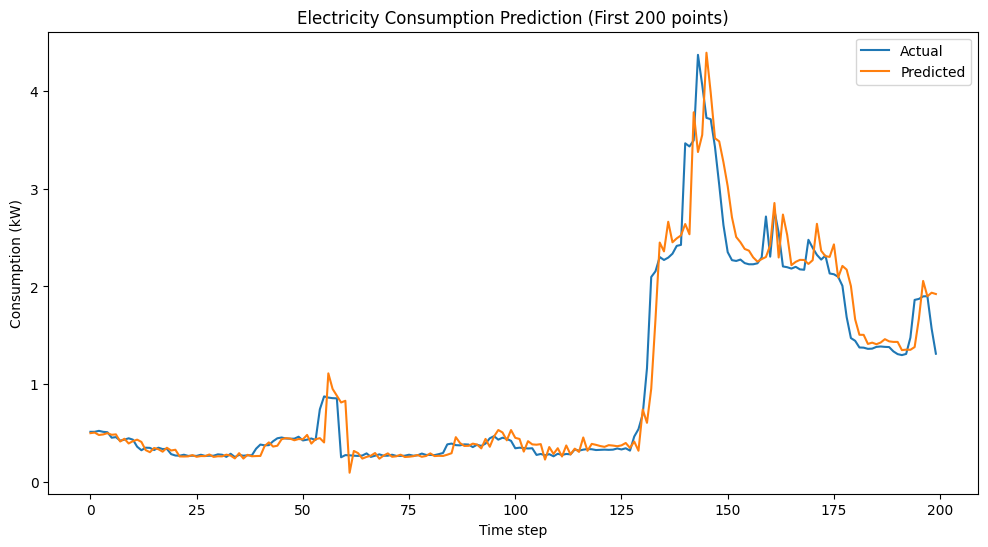

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

file_path = "/content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption_clean.csv"
df = pd.read_csv(file_path)
print("Data preview:")
print(df.head())

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['prev_consumption', 'hour', 'day', 'month', 'consumption']])

# Create sequences for LSTM
def create_sequences(data, seq_length=24):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, :-1])  # features
        y.append(data[i, -1])                # target
    return np.array(X), np.array(y)

seq_length = 24  # previous 24 hours
X, y = create_sequences(scaled_data, seq_length)

# train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

#  LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Training
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

#Prediction
y_pred = model.predict(X_test)

# Inverse scale for comparison
y_test_scaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_test), 4)), y_test.reshape(-1,1)], axis=1))[:, -1]
y_pred_scaled = scaler.inverse_transform(np.concatenate([np.zeros((len(y_pred), 4)), y_pred], axis=1))[:, -1]


mae = mean_absolute_error(y_test_scaled, y_pred_scaled)
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred_scaled))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")


plt.figure(figsize=(12,6))
plt.plot(y_test_scaled[:200], label='Actual')
plt.plot(y_pred_scaled[:200], label='Predicted')
plt.title("Electricity Consumption Prediction (First 200 points)")
plt.xlabel("Time step")
plt.ylabel("Consumption (kW)")
plt.legend()
plt.show()